<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [3]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'


In [4]:
!pip install torchmetrics
import torchmetrics  # Metrics computation for PyTorch models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [5]:
# General Imports
import os
import random
import glob  # File path expansion (finding files matching a pattern)
import json  # JSON serialization and deserialization
import gc  # Garbage collection for memory management
import time  # Time-related functions
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import skimage.draw  # Drawing primitives on images
from tqdm import tqdm, trange  # Progress bars for loops
from IPython.display import Image
from skimage import io  # Image I/O operations
from datetime import datetime

# Data Science and Math Libraries
import numpy as np
import pandas as pd

# Scikit-Learn Imports
from sklearn.preprocessing import StandardScaler, normalize  # Data preprocessing

# PyTorch Imports
import torch
import torch.nn as nn  # Neural network modules and loss functions
import torch.optim as optim  # Optimization algorithms
from torchvision import transforms  # Image transformations
import torchvision  # Computer vision library
from torch.utils.data import DataLoader  # Data loading utility

# Additional Imports
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
import matplotlib.image as mpimg  # Reading and displaying images

# 2. Data Prepration

## 2.1. Creating DataFrame

To handle the dataset, we initialize a dataframe and extract crucial details from it. This involves parsing annotations stored in JSON files for each subset of the dataset (train, valid, test). For each image, the program locates the corresponding annotation, retrieves pertinent data, and organizes it into lists. In case an annotation is absent for an image, a warning message is printed. Finally, a dictionary named 'dic' is constructed, consolidating all the extracted information.


In [6]:
"""
Read JSON files and extract image and annotation information.
Store them in lists and then create a dictionary.
Finally create a pandas dataframe using the dctionary.
"""

file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open(os.path.join(root_dir,s,'_annotations.coco.json'),'r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check if the annotation is available
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']: # if the aanotation is found,extracted the 'category_id' and 'segmentation' from the annotation and append.
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}

df = pd.DataFrame.from_dict(dic)
df.head()

Annotation is missing for image 1380 in train


,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",train


In [7]:
0subset_counts = df['subset'].value_counts()
subset_counts

subset
train    1501
valid     429
test      215
Name: count, dtype: int64

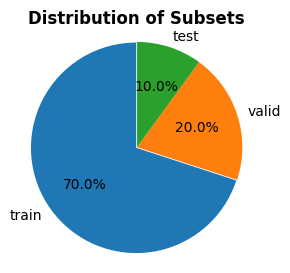

In [8]:
# Count the occurrences of each subset
subset_counts = df['subset'].value_counts()

explode = (0.01, 0, 0)

plt.figure(figsize=(3, 3))
plt.pie(subset_counts, labels=subset_counts.index, autopct='%1.1f%%',startangle=90, explode=explode)
plt.title('Distribution of Subsets', weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## 2.2 Creating a mask

In [9]:
def create_mask(image_info):

  """ - The function aims to create a binary mask based on the segmentation information provided.
        It iterates over each segmentation entry in the image_info['segmentation'] list.
        it extracts the polygon coordinates from the segmentation list.
        pixels inside the segmented regions are set to 1 and pixels outside are set to 0.
  """
  mask_np = np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)

  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np

## 2.3 Data Images Glimpse, Class 1 and Class 2 are both Tumor

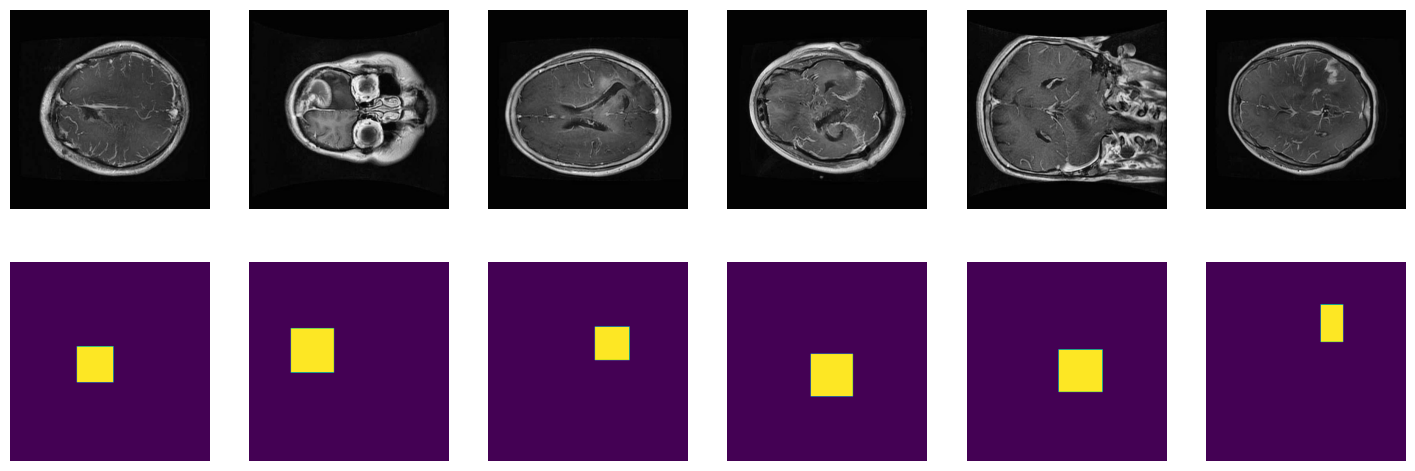

In [10]:
samp = df[df['category_id']==1].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()


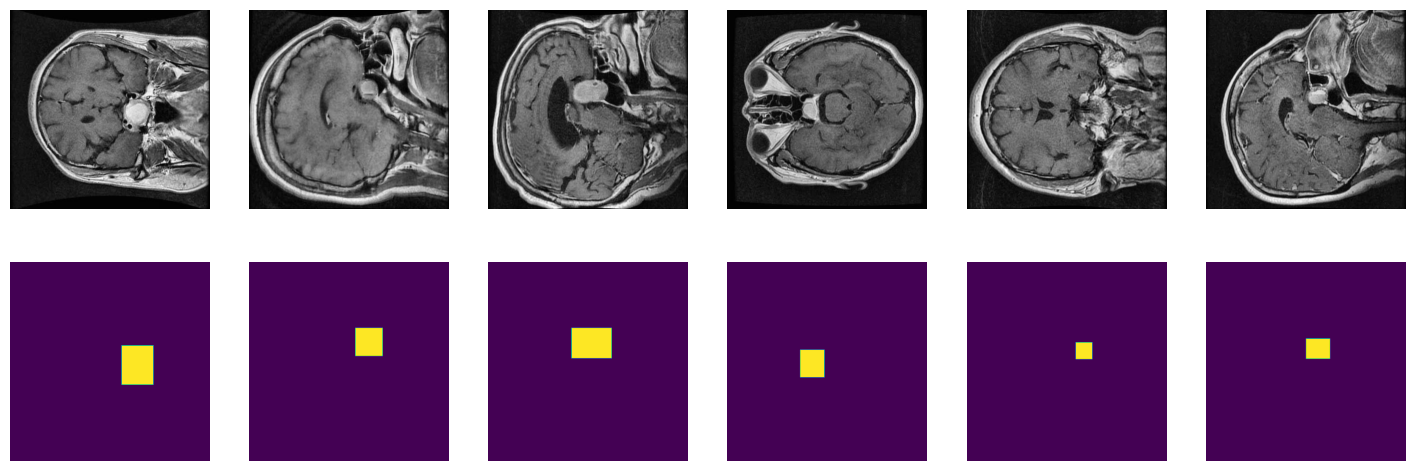

In [11]:
samp = df[df['category_id']==2].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()

## 3.Dataset Class

In [12]:
"""
Dataset class. Read images and create an iterator used in the dataloader.
"""
class SegmentationDataset():
    def __init__(self, root_dir, df, subset, max_samp=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        if max_samp is None:
          max_samp = len(df)

        self.data_ = []  # Loading image-mask pairs from the dataset into memory and storing them in a list called self.data_.

        for i in tqdm(range(max_samp), desc=subset):
          img = cv2.imread(os.path.join(root_dir,subset,df.loc[i]['file_name']))
         # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          mask = create_mask(df.loc[i]) # Create mask
          self.data_.append({'image': img, 'mask': mask}) # add image and its mask to a list.

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):

        image = self.data_[idx]['image']
        mask = self.data_[idx]['mask']


        if self.transform is not None:
          image = self.transform['image'](image)
          mask = self.transform['mask'](mask)
          mask[mask>0] = 1.0


        return image, mask

## 4.Data Transformation

In [13]:
# Define the mean and standard deviation for normalization  or getting my own mean and std?
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformations for images and masks.
transform_img = transforms.Compose([
    #transforms.RandomBrightness(0.1), # Apply random brightness augmentation to improve the contrast and visisbility
    transforms.ToTensor(), # converting image data from a numpy array or PIL image format to a PyTorch tensor format.
    transforms.Normalize(mean=mean, std=std) # normalize the image
])

transform_mask = transforms.Compose([
   # transforms.RandomBrightness(0.1), # Apply random brightness augmentation
    transforms.ToTensor(),
    transforms.Resize((320, 320)), # convert mask to PyTorch tensor
    #transforms.Normalize(mean=[0], std=[1]) # normalize the mask
])

transform = {'image': transform_img , 'mask': transform_mask}

- obtained from the ImageNet dataset In practice, the mean and standard deviation values for normalization are often hard-coded or stored as constants in the code,

## 5.Creating train, validation and test dataloaders

In [14]:
"""
Create train and validation dataloaders.
"""

# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'].reset_index(drop=True), subset='train', max_samp=224, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataloader.
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='valid'].reset_index(drop=True), subset='valid', max_samp=50, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)

# Test dataloader.
#test_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='test'].reset_index(drop=True), subset='test', max_samp=50, transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

valid: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


## 6. Model Architecture (Unet with backbone of ResNet)

In [15]:

import torchvision.models as models # provide access to pre-trained models


In [16]:
class ResNetUNet(nn.Module):
    def __init__(self, num_classes=1, out_channels=1,):
        super(ResNetUNet, self).__init__()

        # Load pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)  # import torchvision

        # Remove fully connected layers (classifier) from ResNet
        self.encoder = nn.Sequential(*list(resnet.children())[:-2]) #remove two last layer,

        # Decoder with transposed convolution
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )


        # Decoder with upsampling (interpolation)
        self.decoder_up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder_up(x)
        return x

# Test the model
#model = ResNetUNet()
#print(model)


## 7. Model Initialization, loss, Optimizer

In [26]:
# Initialize the model, loss function, and optimizer
# learning rate, batch size, and regularization strength
model = ResNetUNet()
criterion = nn.BCEWithLogitsLoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class.
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

evaluate the difference between the predicted segmentation mask and the ground truth mask.
Common loss functions for segmentation tasks include the Dice loss, cross-entropy loss, and focal loss.

During training, the CNN updates its weights to minimize the difference between the predicted segmentation mask and the ground truth mask.

## 8. PyTorch Setup for Training Loop with GPU Compatibility

In [27]:
# Set the max number of epochs, and validation step.

num_epochs = 200
valid_step = 5
ckpt_step = 5
# Set the device to GPU if availabel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device.
model.to(device)
#print(model)

ResNetUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [19]:
x = torch.randn(1, 3, 640, 640).cuda()  # Batch size 1, single channel image of size 80x80
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 320, 320])


## 9. Training

In [28]:
# Training loop

resume_ckp = None
exp_id ='exp_2'
out_dir = os.path.join('Model_Checkpoints',exp_id)
os.makedirs(out_dir,exist_ok=True)


if resume_ckp:
  ckp_path = os.path.join('Model_Checkpoints',exp_id,resume_ckp)
  checkpoint = torch.load(ckp_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  init_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  loss_log = np.load(s.path.join('Model_Checkpoints',exp_id,'loss_log'), allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']
else:
  init_epoch = 0
  train_loss = []
  valid_loss = []



log_path = os.path.join(out_dir,datetime.now().strftime('loss_log.npy'))

for epoch in range(init_epoch,num_epochs):
    model.train()
    running_loss = 0.0
    for step, (images, masks) in enumerate(train_loader):


        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append([epoch, epoch_loss])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch % ckpt_step == 0 or epoch == num_epochs-1:
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(out_dir,f'ckp_{epoch}.pt'))


      np.save(log_path, {'train': train_loss,'valid': valid_loss})


    # Validation
    if epoch % valid_step == 0 or epoch == num_epochs-1:
      model.eval()
      valid_loss_sum = 0
      with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            valid_loss_sum += criterion(outputs, masks).item() * images.size(0)

        avg_valid_loss = valid_loss_sum / len(valid_loader.dataset)
        valid_loss.append([epoch, avg_valid_loss])
        print(f"Average Valid Loss: {avg_valid_loss:.4f}")
        np.save(log_path, {'train': train_loss,'valid': valid_loss})






Epoch [1/200], Loss: 0.7746
Average Valid Loss: 0.7697
Epoch [2/200], Loss: 0.7699
Epoch [3/200], Loss: 0.7653
Epoch [4/200], Loss: 0.7609
Epoch [5/200], Loss: 0.7566
Epoch [6/200], Loss: 0.7526
Average Valid Loss: 0.7471
Epoch [7/200], Loss: 0.7487
Epoch [8/200], Loss: 0.7448
Epoch [9/200], Loss: 0.7409
Epoch [10/200], Loss: 0.7367
Epoch [11/200], Loss: 0.7322
Average Valid Loss: 0.7300
Epoch [12/200], Loss: 0.7273
Epoch [13/200], Loss: 0.7220
Epoch [14/200], Loss: 0.7164
Epoch [15/200], Loss: 0.7104
Epoch [16/200], Loss: 0.7042
Average Valid Loss: 0.7005
Epoch [17/200], Loss: 0.6975
Epoch [18/200], Loss: 0.6907
Epoch [19/200], Loss: 0.6833
Epoch [20/200], Loss: 0.6757
Epoch [21/200], Loss: 0.6678
Average Valid Loss: 0.6633
Epoch [22/200], Loss: 0.6593
Epoch [23/200], Loss: 0.6505
Epoch [24/200], Loss: 0.6412
Epoch [25/200], Loss: 0.6316
Epoch [26/200], Loss: 0.6215
Average Valid Loss: 0.6163
Epoch [27/200], Loss: 0.6109
Epoch [28/200], Loss: 0.6000
Epoch [29/200], Loss: 0.5884
Epoch 

In [21]:
torch.cuda.empty_cache()

Text(0.5, 0.98, 'Training and Validation Loss Curves')

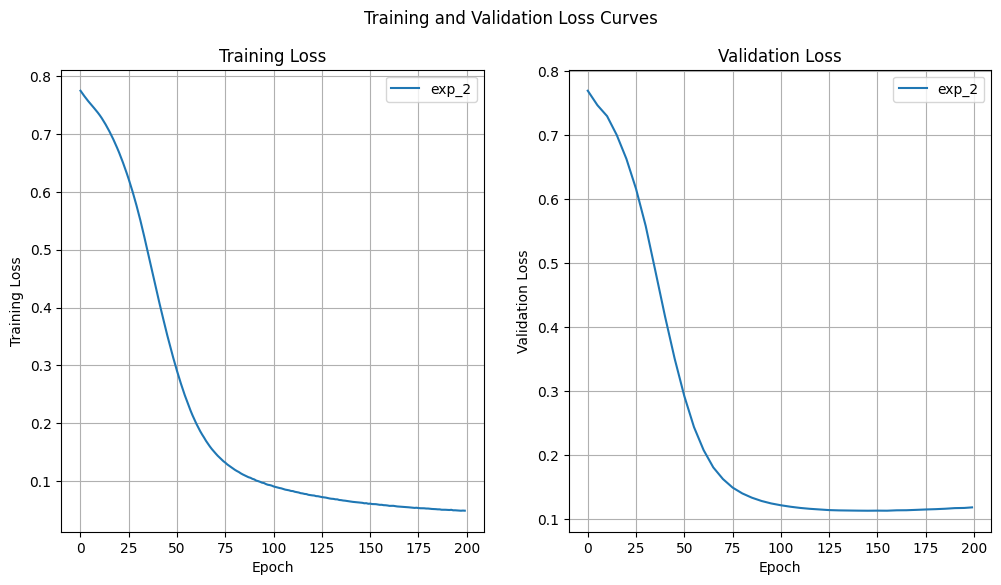

In [29]:
"""
Plot train and validation curves
"""

exp_ids = ['exp_2']
xlim_ = 5
ylim_ = 0.1

fig, axes = plt.subplots (1,2,figsize=(12,6))

for exp in exp_ids:

  in_path = os.path.join('Model_Checkpoints',exp_id,'loss_log.npy')
  loss_log = np.load(in_path, allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']

  axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
  axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])




#axes[0].set_xlim(0, xlim_)
#axes[1].set_xlim(0, xlim_)
#axes[0].set_ylim(0, ylim_)
#axes[1].set_ylim(0, ylim_)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend(exp_ids)
axes[1].legend(exp_ids)

fig.suptitle('Training and Validation Loss Curves')


In [30]:
def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

IoU:0.33, Acc:0.97, Dice:0.50, Precision:0.48, Recall:0.51


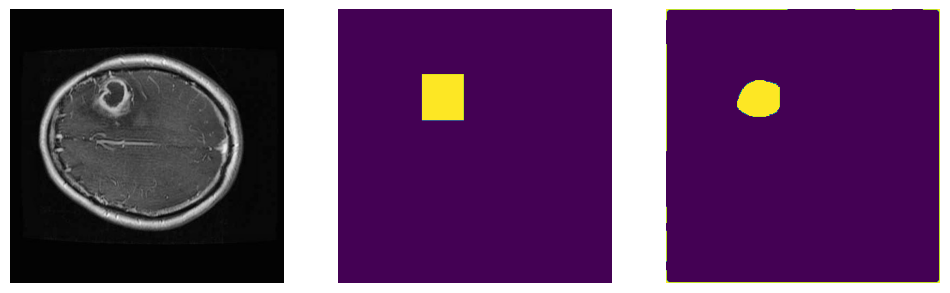

In [33]:
"""
Visualize sample validation result.
"""

#model = ResNetUNet()

# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_2','ckp_125.pt')
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid

idx=32

mask = valid_dataset.data_[idx]['mask']
mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
mask[mask>0] = 1.0

image = valid_dataset.data_[idx]['image']
img = valid_dataset.transform['image'](image)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
  pred = model(img)
pred = pred.squeeze(0)
pred = pred.squeeze(0)
pred = sigmoid(pred).cpu().numpy()

thresh=0.2
pred[pred>thresh]=1.0
pred[pred<=thresh]=0.0


iou_val = iou(mask, pred)
acc_val = accuracy(mask, pred)
dice_val = dice_coef(mask, pred)
prec_val = precision_score_(mask, pred)
rec_val = recall_score_(mask, pred)

print('IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


# Plot the image, mask, and prediction
fig, axes = plt.subplots (1,3,figsize=(12,6))
axes[0].imshow(image)
axes[1].imshow(mask)
axes[2].imshow(pred)

for i in range(3):
  axes[i].axis('off')


In [34]:

# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_2','ckp_125.pt')
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid

idx=32
image = valid_dataset.data_[idx]['image']
mask = valid_dataset.data_[idx]['mask']

mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
mask[mask>0] = 1.0

img = valid_dataset.transform['image'](image)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
  pred = model(img)
pred = pred.squeeze(0)
pred = pred.squeeze(0)
pred = sigmoid(pred).cpu().numpy()

thresh=0.2   #convert prediction from probability into a category
pred[pred>thresh]= 1.0
pred[pred<=thresh]= 0.0

iou_val = iou(mask, pred)
acc_val = accuracy(mask, pred)
dice_val = dice_coef(mask, pred)
prec_val = precision_score_(mask, pred)
rec_val = recall_score_(mask, pred)

print('IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


IoU:0.33, Acc:0.97, Dice:0.50, Precision:0.48, Recall:0.51
